In [1]:
# Core data analysis packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from scipy.sparse import csr_matrix 
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# import our files
user_artists = pd.read_csv('data/user_artists.dat',sep='\t')
artists = pd.read_csv('data/artists.dat',sep='\t',usecols=['id','name'])
tags = pd.read_csv('data/tags.dat', sep='\t',encoding='latin-1')
uta = pd.read_csv('data/user_taggedartists.dat', sep='\t')
utat = pd.read_csv('data/user_taggedartists-timestamps.dat', sep="\t")
friends = pd.read_csv('data/user_friends.dat', sep='\t')

## Step 2: Exploratory Data Analysis (EDA) and Preprocessing

In [3]:
num_users = user_artists['userID'].nunique()
num_artists = user_artists['artistID'].nunique()
print(f"Total users: {num_users}, Total artists: {num_artists}")

Total users: 1892, Total artists: 17632


In [4]:
#Create a binary version: 1 if a user has played the artist at least 1000 time. We will use this later to decide the commun neighbors.
user_artists['played'] = (user_artists['weight'] > 500).astype(int)

In [5]:
user_artists.weight.describe() # 75% of the users have played the artist less than 187 times. The max is 352698

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

## Step 3: Building the Graph Representation

In [6]:
B = nx.Graph()

users = user_artists['userID'].unique()
B.add_nodes_from(users, bipartite='users')

artist_ids = user_artists['artistID'].unique()
artist_nodes = [f"artist_{artist}" for artist in artist_ids]
B.add_nodes_from(artist_nodes, bipartite='artists')

edges = []
for row in user_artists.itertuples(index=False):
    user_id = row.userID
    artist_id = row.artistID
    played = row.played
    edges.append((user_id, f"artist_{artist_id}", played))
    
B.add_weighted_edges_from(edges)

print("Total nodes in bipartite graph:", B.number_of_nodes())
print("Total edges in bipartite graph:", B.number_of_edges())


Total nodes in bipartite graph: 19524
Total edges in bipartite graph: 92834


## Step 3: Build the user-user graph

In [7]:
from networkx.algorithms import bipartite

# Project the bipartite graph onto the user nodes.
user_graph = bipartite.weighted_projected_graph(B, users)

print("Total nodes in user graph:", user_graph.number_of_nodes())
print("Unique users:", len(users)) # just to ensure what we are doing is correct

Total nodes in user graph: 1892
Unique users: 1892


In [8]:
print("Total nodes in user graph:", user_graph.number_of_nodes())
print("Total edges in user graph:", user_graph.number_of_edges())

Total nodes in user graph: 1892
Total edges in user graph: 1014138


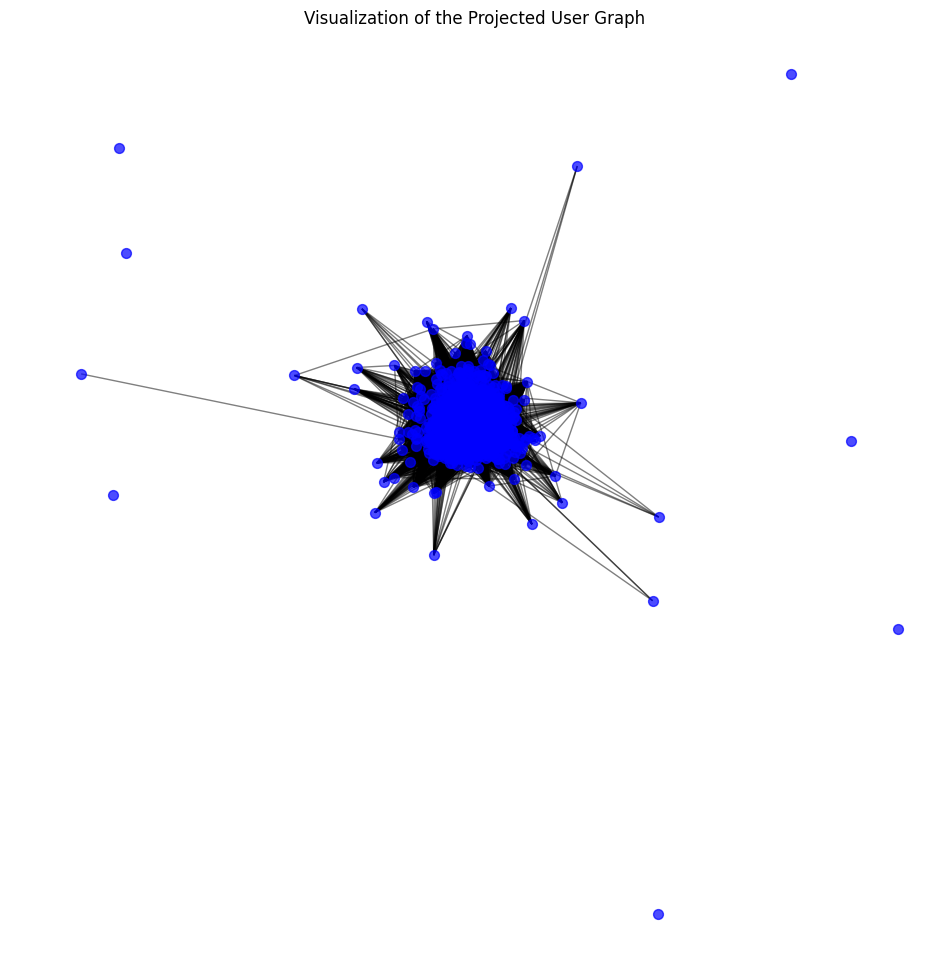

In [9]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(user_graph, k=0.1, iterations=20)
nx.draw_networkx_nodes(user_graph, pos, node_size=50, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(user_graph, pos, alpha=0.5)
plt.title("Visualization of the Projected User Graph")
plt.axis('off')
plt.show()

In [10]:
# Create candidate pairs (for all pairs where u < v)
candidate_pairs = [(u, v) for u in user_graph.nodes() for v in user_graph.nodes() if u < v]

# 1. Jaccard Coefficient
jaccard_scores = list(nx.jaccard_coefficient(user_graph, candidate_pairs))
print("Some Jaccard Coefficient scores:")
for u, v, coeff in jaccard_scores[:5]:
    print(f"Users ({u}, {v}) -> Jaccard: {coeff:.3f}")

Some Jaccard Coefficient scores:
Users (2, 3) -> Jaccard: 0.027
Users (2, 4) -> Jaccard: 0.676
Users (2, 5) -> Jaccard: 0.558
Users (2, 6) -> Jaccard: 0.315
Users (2, 7) -> Jaccard: 0.631


In [15]:
# 2. Adamic–Adar Index
adamic_adar_scores = list(nx.adamic_adar_index(user_graph, candidate_pairs))
print("\nSome Adamic–Adar scores:")
for u, v, aa_score in adamic_adar_scores[:5]:
    print(f"Users ({u}, {v}) -> Adamic–Adar: {aa_score:.3f}")


Some Adamic–Adar scores:
Users (2, 3) -> Adamic–Adar: 5.348
Users (2, 4) -> Adamic–Adar: 155.660
Users (2, 5) -> Adamic–Adar: 133.822
Users (2, 6) -> Adamic–Adar: 62.116
Users (2, 7) -> Adamic–Adar: 128.081


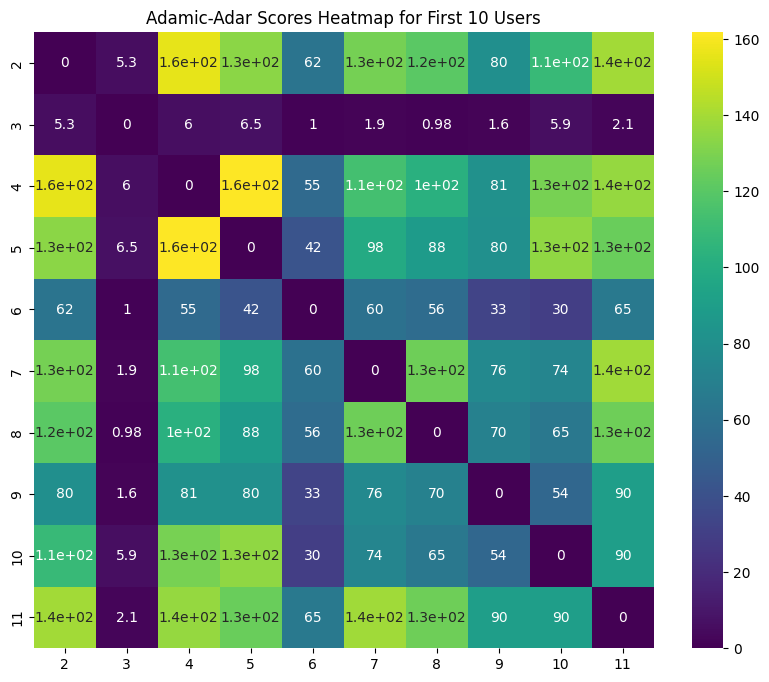

In [19]:
# Extract the first 10 users
first_10_users = users[:10]

# Create a matrix to store the Adamic-Adar scores
aa_matrix = np.zeros((10, 10))

# Fill the matrix with the Adamic-Adar scores
for u, v, aa_score in adamic_adar_scores:
    if u in first_10_users and v in first_10_users:
        i = np.where(first_10_users == u)[0][0]
        j = np.where(first_10_users == v)[0][0]
        aa_matrix[i, j] = aa_score
        aa_matrix[j, i] = aa_score  # Symmetric matrix

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(aa_matrix, xticklabels=first_10_users, yticklabels=first_10_users, cmap='viridis', annot=True)
plt.title("Adamic-Adar Scores Heatmap for First 10 Users")
plt.show()

In [18]:
# 3. Common Neighbors for a specific pair:
def common_neighbors_score(u, v, G):
    """Return the number of common neighbors between u and v."""
    return len(list(nx.common_neighbors(G, u, v)))

u, v = 4, 2
if u in user_graph and v in user_graph:
    cn = common_neighbors_score(u, v, user_graph)
    print(f"\nCommon Neighbors between user {u} and user {v}: {cn}")
else:
    print("User 1 and/or User 2 not found in the graph.")


Common Neighbors between user 4 and user 2: 1099
